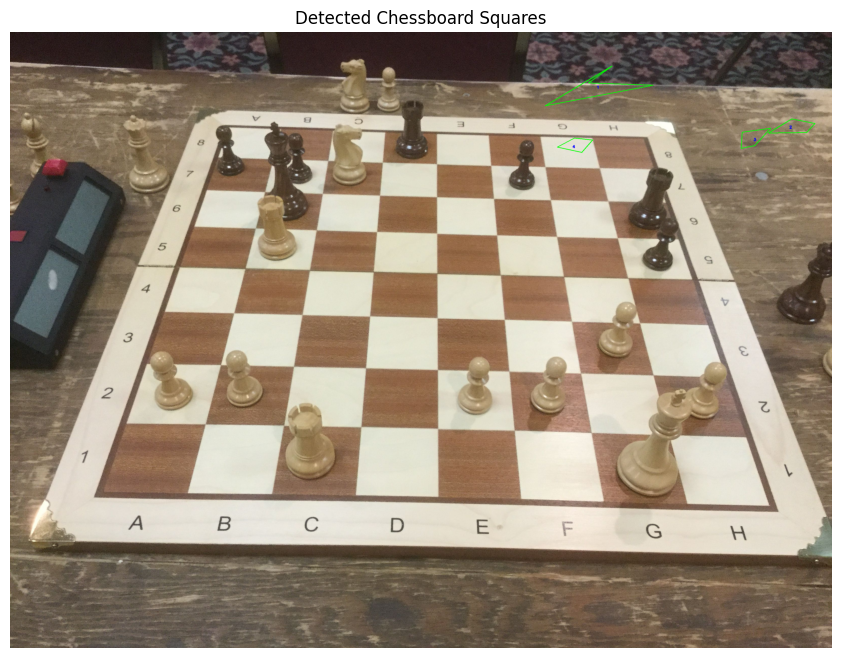

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess the image
image = cv2.imread(r"/home/dev303/Pictures/Screenshots/chessboard.jpeg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Use adaptive thresholding for better edge detection under varied lighting
adaptive_thresh = cv2.adaptiveThreshold(
    gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2
)

# Morphological operations to clean noise and connect edges
kernel = np.ones((3, 3), np.uint8)
cleaned = cv2.morphologyEx(adaptive_thresh, cv2.MORPH_CLOSE, kernel, iterations=2)

# Detect edges
edges = cv2.Canny(cleaned, 50, 150)

# Detect lines using Hough Line Transformation
lines = cv2.HoughLinesP(edges, 1, np.pi / 180, 100, minLineLength=50, maxLineGap=20)

# Overlay detected lines on the image
line_img = np.zeros_like(image)
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(line_img, (x1, y1), (x2, y2), (255, 255, 255), 2)

# Combine lines and edges
combined = cv2.addWeighted(edges, 0.8, cv2.cvtColor(line_img, cv2.COLOR_BGR2GRAY), 0.2, 0)

# Find contours to detect potential squares
contours, _ = cv2.findContours(combined, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
squares = []
for contour in contours:
    area = cv2.contourArea(contour)
    if 4000 < area < 20000:  # Filter based on area
        approx = cv2.approxPolyDP(contour, 0.02 * cv2.arcLength(contour, True), True)
        if len(approx) == 4:  # Ensure quadrilaterals
            squares.append(approx)

# Sort squares for a logical grid layout
sorted_squares = sorted(squares, key=lambda x: (x.ravel()[1], x.ravel()[0]))

# Draw detected squares and label them
for i, square in enumerate(sorted_squares):
    cv2.drawContours(image, [square], -1, (0, 255, 0), 2)
    x, y, w, h = cv2.boundingRect(square)
    center_x, center_y = x + w // 2, y + h // 2
    cv2.putText(image, str(i + 1), (center_x - 10, center_y + 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

# Display results
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Detected Chessboard Squares")
plt.axis("off")
plt.show()
